# 코스피 지수에 대한 탐색적 데이터 분석

In [1]:
# Data Analysis and Visualization
import pandas                as pd
import numpy                 as np
from   sklearn.preprocessing import MinMaxScaler
import talib # TA-Lib은 금융 시장 데이터의 기술적 분석을 수행하는데 필요한 멀티플랫폼 라이브러리 입니다.
# Visualization
import matplotlib           as mpl
from   matplotlib           import font_manager, rc
import matplotlib.pyplot    as plt
import seaborn              as sns
import mplfinance           as mpf # 주가데이터 가져오기
import plotly.graph_objects as go
import plotly.subplots      as ms
# Time Handling
import time
from   pytz     import timezone
from   datetime import date, datetime, timedelta
# HTTP Requests
from urllib.request import urlopen
# Data Sources
from   pykrx             import stock, bond
from pandas_datareader import data as pdr
import yfinance as yfin
# Configurations
import warnings
yfin.pdr_override()

In [2]:
# Add every font at the specified location
font_dir = ['C:/python/fonts']
for font in font_manager.findSystemFonts(fontpaths=font_dir):
    print(mpl.font_manager.FontProperties(fname=font).get_name())
    font_manager.fontManager.addfont(font)
# Set font family globally
mpl.rcParams['font.family'] = 'SeoulNamsan'

Nanum Pen
SeoulNamsan
NanumGothic
NanumGothic
NanumGothic


In [3]:
warnings.filterwarnings('ignore')             # 경고 무시
# Date Strings
YESTERDAY             = datetime.strftime(datetime.now(timezone('Asia/Seoul')) - timedelta(1)  , "%Y-%m-%d") # Yesterday (Format:"YYYYMMDD")
PREVIOUS_BUSINESS_DAY = datetime.strftime(datetime.now(timezone('Asia/Seoul')) - timedelta(3)  , "%Y-%m-%d") if datetime.now(timezone('Asia/Seoul')).weekday() == 0 else YESTERDAY # Previous Business Day (Format:"YYYYMMDD")
TODAY                 = datetime.strftime(datetime.now(timezone('Asia/Seoul'))                 , "%Y-%m-%d") # Yesterday (Format:"YYYYMMDD")
TOMORROW              = datetime.strftime(datetime.now(timezone('Asia/Seoul')) + timedelta(1)  , "%Y-%m-%d") # Yesterday (Format:"YYYYMMDD")
LAST_YEAR             = datetime.strftime(datetime.now(timezone('Asia/Seoul')) - timedelta(365), "%Y")     # Last year (Format:"YYYY")
CURRENT_YEAR          = datetime.strftime(datetime.now(timezone('Asia/Seoul'))                 , "%Y")     # Current year (Format:"YYYY")

WORLD_INDEX_TICKERS = [ {'ticker':'^GSPC'} ]

In [4]:
# Tickers of World Indexes
WORLD_INDEX_TICKERS = [ {'ticker':'^GSPC',     'nation':'US',          'name':'S&P 500'},
                        {'ticker':'^IXIC',     'nation':'US',          'name':'NASDAQ Composite'},
                        {'ticker':'^N225',     'nation':'Japan',       'name':'Nikkei 225'},
                        {'ticker':'399001.SZ', 'nation':'China',       'name':'Shenzhen Index'},
                        {'ticker':'^KS11',     'nation':'Korea',       'name':'KOSPI Composite Index'},
]

In [5]:
def get_world_index(ticker, startDt="2000-01-01", endDt=YESTERDAY):
    """
    세계 주요 주가 지수의 일별 OHCLV(Open, High, Close, Low, Volume) 데이터를 담은 DataFrame을 반환한다.
    [Parameters]
    ticker  (str) : 조회할 지수의 Ticker
    startDt (str) : 조회할 데이터의 시작 일자 (YYYYMMDD) (Default: "20000101")
    endDt   (str) : 조회할 데이터의 종료 일자 (YYYYMMDD) (Default: 전일)
    [Returns]
    pandas.core.frame.DataFrame : 세계 주요 주가 지수의 일별 OHCLV 데이터를 담은 DataFrame
    """
    startDt_datetime = datetime.strptime(startDt, '%Y-%m-%d')
    endDt_datetime   = datetime.strptime(endDt,   '%Y-%m-%d')
    return pdr.get_data_yahoo(ticker, startDt_datetime, endDt_datetime)

def get_normalization(df_ts):
    """
    시계열 데이터를 MinMaxScaler로 정규화한 결과를 반환한다.
    [Parameters]
    df_ts (pandas.core.frame.DataFrame) : 정규화할 시계열 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : 정규화된 시계열 데이터가 담긴 DataFrame
    """
    return MinMaxScaler().fit_transform(df_ts)
def get_RSI(df_stock):
    """
    종목에 대한 DataFrame 형식의 OHLCV를 받아와 14일, 30일, 50일, 200일 RSI를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : RSI를 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : RSI가 계산된 DataFrame
    """
    try:
        for n in [14, 30, 50, 200]:
            df_stock['RSI' + str(n)] = talib.RSI(df_stock['Close'].values, timeperiod = n)
    except:
        df_stock = df_stock.astype('float64')
        for n in [14, 30, 50, 200]:
            df_stock['RSI' + str(n)] = talib.RSI(df_stock['Close'].values, timeperiod = n)
    return df_stock
def get_RSI_OHLCV(df_stock):
    """
    종목에 대한 DataFrame 형식의 OHLCV를 받아와 14일, 30일, 50일, 200일 RSI를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : RSI를 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : RSI가 계산된 DataFrame
    """
    try:
        for n in [14, 30, 50, 200]:
            df_stock['RSI' + str(n)] = talib.RSI(df_stock['종가'].values, timeperiod = n)
    except:
        df_stock = df_stock.astype('float64')
        for n in [14, 30, 50, 200]:
            df_stock['RSI' + str(n)] = talib.RSI(df_stock['종가'].values, timeperiod = n)
    return df_stock
def preprocessing_rsi_backtesting(df_stock):
    """
    기존 전처리한 데이터로 RSI 수익률을 산출하여 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : RSI 수익률을 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : RSI 수익률이 계산된 DataFrame
    """
    df_stock = df_stock.set_index('date')
    # 매매신호 컬럼 생성
    df_stock.loc[df_stock['RSI14']<30,'매매신호'] = True # 1이면 매수신호
    df_stock.loc[df_stock['RSI14']>70,'매매신호'] = False # 0이면 매도신호
    # 일간수익률 컬럼 생성
    df_stock['일간수익률'] = df_stock['Close'].pct_change() + 1
    # 보유여부 컬럼 생성
    df_stock.loc[df_stock['매매신호'].shift(1) == True, '보유여부']=True # 1이면 현재 보유
    df_stock.loc[df_stock['매매신호'].shift(1) == False, '보유여부']=False # 0이면 현재 보유x
    df_stock['보유여부'].ffill(inplace=True)
    df_stock['보유여부'].fillna(False,inplace=True)
    # 보유수익률 컬럼 생성 - 보유하지 않은 날에는 원금을 그대로 유지하므로 해당 거래일의 수익률은 1로 지정.
    df_stock['보유수익률'] = df_stock.loc[df_stock['보유여부']==True,'일간수익률']
    df_stock['보유수익률'].fillna(1,inplace=True)
    # RSI 누적수익률 컬럼 생성
    df_stock['RSI수익률'] = df_stock['보유수익률'].cumprod()
    df_stock['단순보유수익률'] = df_stock['Close'] / df_stock.iloc[0,0]
    return df_stock
def preprocessing_rsi_backtesting_OHLCV(df_stock):
    """
    KRX API를 통해 새로 불러온 데이터로 RSI 수익률을 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : RSI 수익률을 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : RSI 수익률이 계산된 DataFrame
    """
    # 매매신호 컬럼 생성
    df_stock.loc[df_stock['RSI14']<30,'매매신호'] = True # 1이면 매수신호
    df_stock.loc[df_stock['RSI14']>70,'매매신호'] = False # 0이면 매도신호
    # 일간수익률 컬럼 생성
    df_stock['일간수익률'] = df_stock['종가'].pct_change() + 1
    # 보유여부 컬럼 생성
    df_stock.loc[df_stock['매매신호'].shift(1) == True, '보유여부']=True # 1이면 현재 보유
    df_stock.loc[df_stock['매매신호'].shift(1) == False, '보유여부']=False # 0이면 현재 보유x
    df_stock['보유여부'].ffill(inplace=True)
    df_stock['보유여부'].fillna(False,inplace=True)
    # 보유수익률 컬럼 생성 - 보유하지 않은 날에는 원금을 그대로 유지하므로 해당 거래일의 수익률은 1로 지정.
    df_stock['보유수익률'] = df_stock.loc[df_stock['보유여부']==True,'일간수익률']
    df_stock['보유수익률'].fillna(1,inplace=True)
    # RSI 누적수익률 컬럼 생성
    df_stock['RSI수익률'] = df_stock['보유수익률'].cumprod()
    df_stock['단순보유수익률'] = df_stock['종가'] / df_stock.iloc[0,0]
    return df_stock
def scale_rsi_backtesting(scale):
    """
    규모별(코스피,대형주,중형주,소형주) 인덱스에 해당하는 모든 종목들의 rsi 백테스팅 수익률을 반환한다.
    [Parameters]
    scale (str) : RSI 수익률을 계산할 인덱스 (코스피:'kospi' | 대형주:'large' | 중형주:'medium' | 소형주:'small')
    [Returns]
    pandas.core.series.Series : 규모별 각 종목의 RSI 수익률이 계산된 Series
    """
    yeild=[]
    # s 는 각 인덱스에 해당하는 종목
    for s in scale:
        df = stock.get_market_ohlcv('20030301','20220901',s)       # 2000년 3월1일부터 2022년 9월 1일까지의 정보들
        df = get_RSI_OHLCV(df)                              # RSI 컬럼을 생성하는 함수 호출
        df = preprocessing_rsi_backtesting_OHLCV(df)        # RSI 수익률을 구하는 함수 호출
        yeild.append(df.iloc[-1].loc['RSI수익률'])
    s = pd.Series(yeild)
    return s
def df_manipulate_kospi(df_stock):
    """
    시가총액별 KOSPI DataFrame을 받아와 60일, 120일, 360일 MA 및 MA와 지수 사이의 이격도를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : MA를 계산할 데이터가 담긴 DataFrame
    [Returns]
    pandas.core.frame.DataFrame : MA가 계산된 DataFrame
    """
    df_stock = df_stock.set_index('date')
    df_stock = df_stock[['Open', 'High', 'Low', 'Close', 'Volume']]
    df_stock["MA60"] = df_stock['Close'].rolling(window=60).mean() # MA60값 계산
    df_stock["MA120"] = df_stock['Close'].rolling(window=120).mean()
    df_stock["MA360"] = df_stock['Close'].rolling(window=360).mean()
    # MA_sep은 MA선과 그 날의 종가 사이의 이격도를 나타내는 값
    # 1 이상일 때, MA선보다 크게 하락하는 장을 의미하고, 1 이하일 때 MA선보다 크게 상승하는 장을 의미함.
    df_stock["MA60_sep"] = (df_stock["MA60"] / df_stock['Close']) # 지수화된 MA60 계산
    df_stock["MA120_sep"] = (df_stock["MA120"] / df_stock['Close'])
    df_stock["MA360_sep"] = (df_stock["MA360"] / df_stock['Close'])
    return df_stock
def set_date(df_stock, buy, sell):
    """
    문자열 형식의 구매 날짜와 판매 날짜를 입력 받아 해당 기간의 데이터만을 가진 DataFrame을 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : 조회하고자 하는 데이터가 담긴 DataFrame
    buy      (str)                         : 매수일
    sell     (str)                         : 매도일
    [Returns]
    pandas.core.frame.DataFrame : 해당 기간의 데이터만을 가진 DataFrame
    """
    buy = datetime.strptime(buy,'%Y-%m-%d')
    sell = datetime.strptime(sell,'%Y-%m-%d')
    cond1 = df_stock['date'] >= buy
    cond2 = df_stock['date'] <= sell
    return df_stock.loc[cond1 & cond2]
def get_beta(df_stock, df_index, start, end):
    """
    특정 종목과 시장지수를 DataFrame형식으로 받아 시장지수 대비 특정 종목의 베타값을 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : 조회하고자 하는 특정종목의 DataFrame
    df_index (pandas.core.frame.DataFrame) : 조회하고자 하는 시장지수 인덱스 DataFrame
    start    (str)                         : 매수일
    end      (str)                         : 매도일
    [Returns]
    float64 : beta 값
    """
    df_stock = set_date(df_stock, start, end)
    df_index = set_date(df_index, start, end)
    data = pd.concat([df_stock['close'].reset_index(drop=True), df_index['close'].reset_index(drop=True)], axis=1)
    daily_return = np.log(data / data.shift(1))
    cov = daily_return.cov() * 250
    cov_market = cov.iloc[0,1]
    market_var = daily_return.iloc[:,1].var() * 250
    beta = cov_market / market_var
    return round(beta, 3)
def get_corr(df_stock1, df_stock2, start, end):
    """
    특정 두 종목을 DataFrame형식으로 받아 두 종목 간의 상관계수를 반환한다.
    [Parameters]
    df_stock1 (pandas.core.frame.DataFrame) : 조회하고자 하는 특정종목의 DataFrame
    df_stock2 (pandas.core.frame.DataFrame) : 조회하고자 하는 특정종목의 DataFrame
    start    (str)                          : 매수일
    end      (str)                          : 매도일
    [Returns]
    float64 : 상관계수 값
    """
    df_stock1 = set_date(df_stock1, start, end)
    df_stock2 = set_date(df_stock2, start, end)
    data = pd.concat([df_stock1['close'].reset_index(drop=True), df_stock2['close'].reset_index(drop=True)], axis=1)
    daily_return = np.log(data / data.shift(1))
    corr = daily_return.corr().iloc[1,0]
    return round(corr,3)
def get_mdd(df_stock, start, end):
    """
    특정 종목을 DataFrame형식으로 받아 mdd를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : mdd를 구하고자 하는 특정종목의 DataFrame
    start    (str)                         : 시작 날짜
    end      (str)                         : 종료 날짜
    [Returns]
    float64 : mdd 값
    """
    x_mdd = set_date(df_stock,start,end)
    저가 = x_mdd['low'].min() #최저점
    index = x_mdd[x_mdd['low'] == x_mdd['low'].min()].index
    # 저가 기준 전고점 구하기
    전고점기간 = x_mdd.loc[:index[0], :]
    전고점 = 전고점기간['high'].max()
    # MDD 계산
    mdd = round((저가 - 전고점) / 전고점, 4) * 100
    return mdd
def get_mdd_5(df_stock):
    """
    특정 종목을 DataFrame형식으로 받아 2017-09-01 ~ 2022-09-01 5년간의 mdd를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : mdd를 구하고자 하는 특정종목의 DataFrame
    [Returns]
    float64 : 5년 간의 mdd 값
    """
    return get_mdd(df_stock, '2017-09-01', '2022-09-01')
def get_mdd_10(df_stock):
    """
    특정 종목을 DataFrame형식으로 받아 2012-09-01 ~ 2022-09-01 10년간의 mdd를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : mdd를 구하고자 하는 특정종목의 DataFrame
    [Returns]
    float64 : 10년 간의 mdd 값
    """
    return get_mdd(df_stock, '2012-09-01', '2022-09-01')
def get_mdd_200(df_stock):
    """
    특정 종목을 DataFrame형식으로 받아 2018-10-22 ~ 2022-09-01 200주 간의 mdd를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : mdd를 구하고자 하는 특정종목의 DataFrame
    [Returns]
    float64 : 2018-10-22 ~ 2022-09-01 200주 간의 mdd 값
    """
    return get_mdd(df_stock, '2018-10-22', '2022-09-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


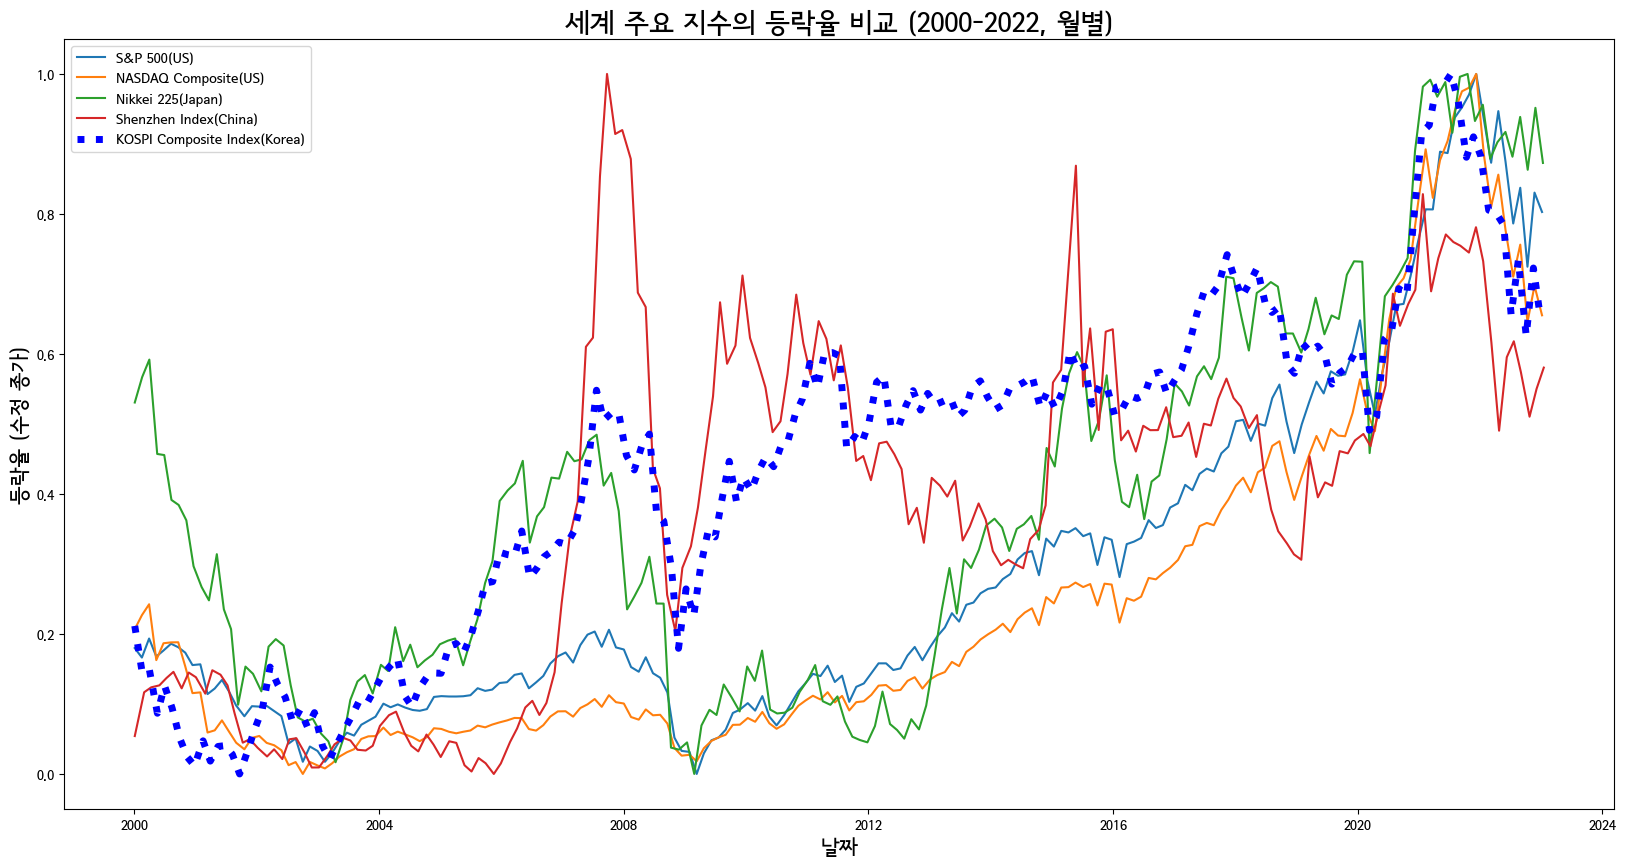

In [6]:
fig = plt.figure( figsize=(20, 10)) # 그래프 크기 조절
for index in WORLD_INDEX_TICKERS:
    index_df    = get_world_index(index['ticker'])[['Close']][::30]
    index_df[:] = get_normalization(index_df)
    if index['ticker'] == '^KS11':
        ax1 = sns.lineplot(
            data      = index_df,
            x         = 'Date',
            y         = 'Close',
            label     = index['name'] + f"({index['nation']})",
            color     = 'blue',
            linewidth = 5,
            linestyle = ':'
        )
    else:
        ax1 = sns.lineplot(
            data    = index_df,
            x       = 'Date',
            y       = 'Close',
            label   = index['name'] + f"({index['nation']})",
        )
plt.title('세계 주요 지수의 등락율 비교 (2000-2022, 월별)', fontsize=20)
plt.ylabel('등락율 (수정 종가)', fontsize=15)
plt.xlabel('날짜', fontsize=15)
plt.legend(loc = 'upper left')
sns.set_theme(style='whitegrid')
plt.show()

## 코스피 섹터별(업종별) 주가 분석

In [7]:
# csv 파일 불러오기
df_sector_month = pd.read_csv('https://drive.google.com/uc?id=1HAtL4rzsydW9vYvBSaH3cMj7j8ekRLqm',encoding='cp949').drop(columns='Unnamed: 0')
df_sector_year = pd.read_csv('https://drive.google.com/uc?id=1hmaEqDe_Wbak0zqgU7XB2mnbbPNJKn8T',encoding='cp949').drop(columns='Unnamed: 0')
df = pd.read_csv('https://drive.google.com/uc?id=1eJuZOdu2PTzzrMJvSXZn1vxN4edme_Dt', encoding='cp949').drop(columns='Unnamed: 0')
df_200 = pd.read_csv('https://drive.google.com/uc?id=1T8LxTflBcPpxUpi_GmicaNPk_8EL29ua', encoding = 'cp949').drop(columns='Unnamed: 0')

# 코스피 200 직접 불러오기
df_kospi_200 = stock.get_index_ohlcv("20181022", "20220901", "1028").reset_index()
temp = df_kospi_200.reset_index()
temp['sector_name'] = stock.get_index_ticker_name('1028')
temp['sector_ticker'] = '1028'
df_kospi_200 = temp[['sector_ticker','sector_name','날짜','시가','종가','고가','저가','거래량','거래대금',
                     '상장시가총액']]

# 칼럼명 영어로 변환
df_kospi_200.columns = ['sector_ticker','sector_name','date','open','close','high','low','volume','volume($)',
                     'Market_Cap']

# 날짜 타입 설정
df['date'] = df['date'].astype("datetime64")
df_200['date'] = df_200['date'].astype("datetime64")
df_kospi_200['date'] = df_kospi_200['date'].astype("datetime64")
df_sector_month['date'] = df_sector_month['date'].astype("datetime64")
df_sector_year['date'] = df_sector_year['date'].astype("datetime64")

# df 섹터별 구분하여 DF 생성
코스피 = df[df['sector_name']=='코스피']
음식료품 = df[df['sector_name']=='음식료품']
섬유의복 = df[df['sector_name']=='섬유의복']
종이목재 = df[df['sector_name']=='종이목재']
화학 = df[df['sector_name']=='화학']
의약품 = df[df['sector_name']=='의약품']
비금속광물 = df[df['sector_name']=='비금속광물']
철강금속 = df[df['sector_name']=='철강금속']
기계 = df[df['sector_name']=='기계']
전기전자 = df[df['sector_name']=='전기전자']
의료정밀 = df[df['sector_name']=='의료정밀']
운수장비 = df[df['sector_name']=='운수장비']
유통업 = df[df['sector_name']=='유통업']
전기가스업 = df[df['sector_name']=='전기가스업']
건설업 = df[df['sector_name']=='건설업']
운수창고업 = df[df['sector_name']=='운수창고업']
건설업 = df[df['sector_name']=='건설업']
통신업 = df[df['sector_name']=='통신업']
금융업 = df[df['sector_name']=='금융업']
은행 = df[df['sector_name']=='은행']
증권 = df[df['sector_name']=='증권']
보험 = df[df['sector_name']=='보험']
서비스업 = df[df['sector_name']=='서비스업']
제조업 = df[df['sector_name']=='제조업']

# 칼럼명 리스트 선언
sector_list=['코스피', '음식료품', '섬유의복', '종이목재', '화학', '의약품', '비금속광물', '철강금속', '기계',
       '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업', '건설업', '운수창고업', '통신업',
       '금융업', '은행', '증권', '보험', '서비스업', '제조업']

x_list = [코스피, 음식료품, 섬유의복, 종이목재, 화학, 의약품, 비금속광물, 철강금속, 기계,
       전기전자, 의료정밀, 운수장비, 유통업, 전기가스업, 건설업, 운수창고업, 통신업,
       금융업, 은행, 증권, 보험, 서비스업, 제조업]

time_list = [df_sector_year,df_sector_month]

# df_200 섹터별 구분하여 DF 생성
커뮤니케이션서비스200 = df_200[df_200['sector_name']=='코스피 200 커뮤니케이션서비스']
건설200 = df_200[df_200['sector_name']=='코스피 200 건설']
중공업200 = df_200[df_200['sector_name']=='코스피 200 중공업']
철강소재200 = df_200[df_200['sector_name']=='코스피 200 철강/소재']
에너지화학200 = df_200[df_200['sector_name']=='코스피 200 에너지/화학']
정보기술200 = df_200[df_200['sector_name']=='코스피 200 정보기술']
금융200 = df_200[df_200['sector_name']=='코스피 200 금융']
생활소비재200 = df_200[df_200['sector_name']=='코스피 200 생활소비재']
경기소비재200 = df_200[df_200['sector_name']=='코스피 200 경기소비재']
산업재200 = df_200[df_200['sector_name']=='코스피 200 산업재']
헬스케어200 = df_200[df_200['sector_name']=='코스피 200 헬스케어']

# df_year, df_month 섹터별 구분하여 DF 생성
df_name_list=[]
for i in range(len(time_list)):
    for j in range(len(sector_list)):
        df_name_list.append(time_list[i][time_list[i]['sector_name']==sector_list[j]])
        
# 연도별 섹터별 분리
df_sector_year_코스피=df_name_list[0]
df_sector_year_음식료품=df_name_list[1] 
df_sector_year_섬유의복=df_name_list[2] 
df_sector_year_종이목재=df_name_list[3] 
df_sector_year_화학=df_name_list[4] 
df_sector_year_의약품=df_name_list[5] 
df_sector_year_비금속광물=df_name_list[6]
df_sector_year_철강금속=df_name_list[7] 
df_sector_year_기계=df_name_list[8] 
df_sector_year_전기전자=df_name_list[9] 
df_sector_year_의료정밀=df_name_list[10]
df_sector_year_운수장비=df_name_list[11] 
df_sector_year_유통업=df_name_list[12] 
df_sector_year_전기가스업=df_name_list[13] 
df_sector_year_건설업=df_name_list[14] 
df_sector_year_운수창고업=df_name_list[15] 
df_sector_year_통신업=df_name_list[16]
df_sector_year_금융업=df_name_list[17] 
df_sector_year_은행=df_name_list[18] 
df_sector_year_증권=df_name_list[19] 
df_sector_year_보험=df_name_list[20] 
df_sector_year_서비스업=df_name_list[21] 
df_sector_year_제조업=df_name_list[22]

# 월별 섹터별 분리
df_sector_month_코스피=df_name_list[23]
df_sector_month_음식료품=df_name_list[24]
df_sector_month_섬유의복=df_name_list[25]
df_sector_month_종이목재=df_name_list[26]
df_sector_month_화학=df_name_list[27] 
df_sector_month_의약품=df_name_list[28]
df_sector_month_비금속광물=df_name_list[29] 
df_sector_month_철강금속=df_name_list[30] 
df_sector_month_기계=df_name_list[31]
df_sector_month_전기전자=df_name_list[32]
df_sector_month_의료정밀=df_name_list[33] 
df_sector_month_운수장비=df_name_list[34]
df_sector_month_유통업=df_name_list[35] 
df_sector_month_전기가스업=df_name_list[36] 
df_sector_month_건설업=df_name_list[37] 
df_sector_month_운수창고업=df_name_list[38] 
df_sector_month_통신업=df_name_list[39] 
df_sector_month_금융업=df_name_list[40] 
df_sector_month_은행=df_name_list[41] 
df_sector_month_증권=df_name_list[42] 
df_sector_month_보험=df_name_list[43]
df_sector_month_서비스업=df_name_list[44] 
df_sector_month_제조업=df_name_list[45] 

# 연도별 index DF 선언
df_sector_year_코스피_index = (df_sector_year_코스피['Close'] / df_sector_year_코스피['Close'].iloc[0]) * 100
df_sector_year_음식료품_index = (df_sector_year_음식료품['Close'] / df_sector_year_음식료품['Close'].iloc[0]) * 100
df_sector_year_섬유의복_index = (df_sector_year_섬유의복['Close'] / df_sector_year_섬유의복['Close'].iloc[0]) * 100
df_sector_year_종이목재_index = (df_sector_year_종이목재['Close'] / df_sector_year_종이목재['Close'].iloc[0]) * 100
df_sector_year_화학_index = (df_sector_year_화학['Close'] / df_sector_year_화학['Close'].iloc[0]) * 100
df_sector_year_의약품_index = (df_sector_year_의약품['Close'] / df_sector_year_의약품['Close'].iloc[0]) * 100
df_sector_year_비금속광물_index = (df_sector_year_비금속광물['Close'] / df_sector_year_비금속광물['Close'].iloc[0]) * 100
df_sector_year_철강금속_index = (df_sector_year_철강금속['Close'] / df_sector_year_철강금속['Close'].iloc[0]) * 100
df_sector_year_기계_index = (df_sector_year_기계['Close'] / df_sector_year_기계['Close'].iloc[0]) * 100
df_sector_year_전기전자_index = (df_sector_year_전기전자['Close'] / df_sector_year_전기전자['Close'].iloc[0]) * 100
df_sector_year_의료정밀_index = (df_sector_year_의료정밀['Close'] / df_sector_year_의료정밀['Close'].iloc[0]) * 100
df_sector_year_운수장비_index = (df_sector_year_운수장비['Close'] / df_sector_year_운수장비['Close'].iloc[0]) * 100
df_sector_year_유통업_index = (df_sector_year_유통업['Close'] / df_sector_year_유통업['Close'].iloc[0]) * 100
df_sector_year_전기가스업_index = (df_sector_year_전기가스업['Close'] / df_sector_year_전기가스업['Close'].iloc[0]) * 100
df_sector_year_건설업_index = (df_sector_year_건설업['Close'] / df_sector_year_건설업['Close'].iloc[0]) * 100
df_sector_year_운수창고업_index = (df_sector_year_운수창고업['Close'] / df_sector_year_운수창고업['Close'].iloc[0]) * 100
df_sector_year_통신업_index = (df_sector_year_통신업['Close'] / df_sector_year_통신업['Close'].iloc[0]) * 100
df_sector_year_금융업_index = (df_sector_year_금융업['Close'] / df_sector_year_금융업['Close'].iloc[0]) * 100
df_sector_year_은행_index = (df_sector_year_은행['Close'] / df_sector_year_은행['Close'].iloc[0]) * 100
df_sector_year_증권_index = (df_sector_year_증권['Close'] / df_sector_year_증권['Close'].iloc[0]) * 100
df_sector_year_보험_index = (df_sector_year_보험['Close'] / df_sector_year_보험['Close'].iloc[0]) * 100
df_sector_year_서비스업_index = (df_sector_year_서비스업['Close'] / df_sector_year_서비스업['Close'].iloc[0]) * 100
df_sector_year_제조업_index = (df_sector_year_제조업['Close'] / df_sector_year_제조업['Close'].iloc[0]) * 100

# 월별 index DF 선언
df_sector_month_코스피_index = (df_sector_month_코스피['Close'] / df_sector_month_코스피['Close'].iloc[0]) * 100
df_sector_month_음식료품_index = (df_sector_month_음식료품['Close'] / df_sector_month_음식료품['Close'].iloc[0]) * 100
df_sector_month_섬유의복_index = (df_sector_month_섬유의복['Close'] / df_sector_month_섬유의복['Close'].iloc[0]) * 100
df_sector_month_종이목재_index = (df_sector_month_종이목재['Close'] / df_sector_month_종이목재['Close'].iloc[0]) * 100
df_sector_month_화학_index = (df_sector_month_화학['Close'] / df_sector_month_화학['Close'].iloc[0]) * 100
df_sector_month_의약품_index = (df_sector_month_의약품['Close'] / df_sector_month_의약품['Close'].iloc[0]) * 100
df_sector_month_비금속광물_index = (df_sector_month_비금속광물['Close'] / df_sector_month_비금속광물['Close'].iloc[0]) * 100
df_sector_month_철강금속_index = (df_sector_month_철강금속['Close'] / df_sector_month_철강금속['Close'].iloc[0]) * 100
df_sector_month_기계_index = (df_sector_month_기계['Close'] / df_sector_month_기계['Close'].iloc[0]) * 100
df_sector_month_전기전자_index = (df_sector_month_전기전자['Close'] / df_sector_month_전기전자['Close'].iloc[0]) * 100
df_sector_month_의료정밀_index = (df_sector_month_의료정밀['Close'] / df_sector_month_의료정밀['Close'].iloc[0]) * 100
df_sector_month_운수장비_index = (df_sector_month_운수장비['Close'] / df_sector_month_운수장비['Close'].iloc[0]) * 100
df_sector_month_유통업_index = (df_sector_month_유통업['Close'] / df_sector_month_유통업['Close'].iloc[0]) * 100
df_sector_month_전기가스업_index = (df_sector_month_전기가스업['Close'] / df_sector_month_전기가스업['Close'].iloc[0]) * 100
df_sector_month_건설업_index = (df_sector_month_건설업['Close'] / df_sector_month_건설업['Close'].iloc[0]) * 100
df_sector_month_운수창고업_index = (df_sector_month_운수창고업['Close'] / df_sector_month_운수창고업['Close'].iloc[0]) * 100
df_sector_month_통신업_index = (df_sector_month_통신업['Close'] / df_sector_month_통신업['Close'].iloc[0]) * 100
df_sector_month_금융업_index = (df_sector_month_금융업['Close'] / df_sector_month_금융업['Close'].iloc[0]) * 100
df_sector_month_은행_index = (df_sector_month_은행['Close'] / df_sector_month_은행['Close'].iloc[0]) * 100
df_sector_month_증권_index = (df_sector_month_증권['Close'] / df_sector_month_증권['Close'].iloc[0]) * 100
df_sector_month_보험_index = (df_sector_month_보험['Close'] / df_sector_month_보험['Close'].iloc[0]) * 100
df_sector_month_서비스업_index = (df_sector_month_서비스업['Close'] / df_sector_month_서비스업['Close'].iloc[0]) * 100
df_sector_month_제조업_index = (df_sector_month_제조업['Close'] / df_sector_month_제조업['Close'].iloc[0]) * 100

In [8]:
# 전처리
산업 = df[df['date']=='2022-01-26'][1:]
전체_산업_시총 = 산업['Market_Cap'].sum()
sector_name_list = 산업['sector_name'].unique()
각_산업_시총_비중 = {}

for sec in sector_name_list:
    tmp = (산업[산업['sector_name']==sec]['Market_Cap']).item()
    각_산업_시총_비중[sec] = tmp/전체_산업_시총*100
    
각_산업_시총_비중 = pd.DataFrame(list(각_산업_시총_비중.items()),
                   columns=['산업','비중'])
각_산업_시총_비중 = 각_산업_시총_비중.sort_values(by='비중',ascending=False)
ratio = 각_산업_시총_비중['비중']
labels = 각_산업_시총_비중['산업']

In [9]:
sector_list=['코스피', '음식료품', '섬유의복', '종이목재', '화학', '의약품', '비금속광물', '철강금속', '기계',
       '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업', '건설업', '운수창고업', '통신업',
       '금융업', '은행', '증권', '보험', '서비스업', '제조업']

x_list = [코스피, 음식료품, 섬유의복, 종이목재, 화학, 의약품, 비금속광물, 철강금속, 기계,
       전기전자, 의료정밀, 운수장비, 유통업, 전기가스업, 건설업, 운수창고업, 통신업,
       금융업, 은행, 증권, 보험, 서비스업, 제조업]

# 베타 구하기
beta = []
for x in x_list:
    beta.append(get_beta(코스피,x,'2022-01-01','2022-09-01'))

tmp={}
for i in range(len(x_list)):
    tmp[sector_list[i]] = beta[i]
    
tmp = pd.DataFrame(list(tmp.items()),
                   columns=['sector_list','beta'])
beta = tmp.sort_values(by='beta',ascending=False)
beta = beta.reset_index().drop('index',axis=1)
beta = beta.fillna(0)

In [10]:
corr = {}
x = x_list[0]
for j in range(len(x_list)):
    y = x_list[j]
    corr[sector_list[j]] = get_corr(x,y,'2022-01-01','2022-09-01')
corr = pd.DataFrame(list(corr.items()),columns=['sector_list',sector_list[0]])

for i in range(1,len(x_list)):
    tmp = {}
    x = x_list[i]
    for j in range(len(x_list)):
        y = x_list[j]
        tmp[sector_list[j]] = get_corr(x,y,'2022-01-01','2022-09-01')
    tmp = pd.DataFrame(list(tmp.items()),columns=['sector_list',sector_list[i]])
    corr = pd.merge(corr,tmp)  
corr = corr.set_index('sector_list')

In [11]:
경제섹터 = df_200[df_200['date']=='2022-09-01']
전체_경제섹터_시총 = 경제섹터['Market_Cap'].sum()
경제섹터_list = 경제섹터['sector_name'].unique()
각_경제섹터_시총_비중 = {}

for sec in 경제섹터_list:
    tmp = (경제섹터[경제섹터['sector_name']==sec]['Market_Cap']).item()
    각_경제섹터_시총_비중[sec] = tmp/전체_경제섹터_시총*100
    
각_경제섹터_시총_비중 = pd.DataFrame(list(각_경제섹터_시총_비중.items()),
                   columns=['경제섹터','비중'])
각_경제섹터_시총_비중 = 각_경제섹터_시총_비중.sort_values(by='비중',ascending=False)
ratio_200 = 각_경제섹터_시총_비중['비중']
labels_200 = 각_경제섹터_시총_비중['경제섹터']

In [12]:
sec_200 = [커뮤니케이션서비스200,건설200,중공업200,철강소재200,에너지화학200,정보기술200,금융200,생활소비재200,경기소비재200,산업재200,헬스케어200]
sec_200_name = ['코스피 200 커뮤니케이션서비스', '코스피 200 건설', '코스피 200 중공업', '코스피 200 철강/소재',
       '코스피 200 에너지/화학', '코스피 200 정보기술', '코스피 200 금융', '코스피 200 생활소비재',
       '코스피 200 경기소비재', '코스피 200 산업재', '코스피 200 헬스케어']

sec_200_corr_dict = {}
temp_list = []
for idx, i in enumerate(sec_200):
    for j in sec_200:
        temp_list.append(get_corr(i,j,'2022-01-01','2022-09-01'))
    sec_200_corr_dict[sec_200_name[idx]] = temp_list
    temp_list = []

상관계수_200 = pd.DataFrame(sec_200_corr_dict, index = sec_200_name)
상관계수_200.reset_index().rename(columns={'index':'상대섹터'})

,상대섹터,코스피 200 커뮤니케이션서비스,코스피 200 건설,코스피 200 중공업,코스피 200 철강/소재,코스피 200 에너지/화학,코스피 200 정보기술,코스피 200 금융,코스피 200 생활소비재,코스피 200 경기소비재,코스피 200 산업재,코스피 200 헬스케어
0,코스피 200 커뮤니케이션서비스,1.000,0.484,0.385,0.464,0.634,0.725,0.525,0.556,0.565,0.617,0.648
1,코스피 200 건설,0.484,1.000,0.766,0.726,0.724,0.574,0.588,0.581,0.593,0.775,0.465
2,코스피 200 중공업,0.385,0.766,1.000,0.669,0.677,0.451,0.482,0.455,0.496,0.738,0.381
3,코스피 200 철강/소재,0.464,0.726,0.669,1.000,0.699,0.557,0.667,0.517,0.569,0.712,0.402
4,코스피 200 에너지/화학,0.634,0.724,0.677,0.699,1.000,0.761,0.613,0.594,0.645,0.795,0.546
5,코스피 200 정보기술,0.725,0.574,0.451,0.557,0.761,1.000,0.544,0.593,0.662,0.666,0.631
6,코스피 200 금융,0.525,0.588,0.482,0.667,0.613,0.544,1.000,0.481,0.546,0.640,0.368
7,코스피 200 생활소비재,0.556,0.581,0.455,0.517,0.594,0.593,0.481,1.000,0.643,0.680,0.555
8,코스피 200 경기소비재,0.565,0.593,0.496,0.569,0.645,0.662,0.546,0.643,1.000,0.646,0.493
9,코스피 200 산업재,0.617,0.775,0.738,0.712,0.795,0.666,0.640,0.680,0.646,1.000,0.578


# 코스피 산업간 상관계수

In [13]:
import matplotlib.font_manager as font_manager
import matplotlib as mpl
# Add every font at the specified location
font_dir = ['C:/python/fonts']
for font in font_manager.findSystemFonts(fontpaths=font_dir):
    print(mpl.font_manager.FontProperties(fname=font).get_name())
    font_manager.fontManager.addfont(font)
# Set font family globally
mpl.rcParams['font.family'] = 'NanumGothic'
print(mpl.rcParams['font.family'])

Nanum Pen
SeoulNamsan
NanumGothic
NanumGothic
NanumGothic
['NanumGothic']


In [14]:
corr

,코스피,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,...,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업,제조업
sector_list,,,,,,,,,,,,,,,,,,,,,
코스피,1.000,0.578,0.618,0.730,0.869,0.677,0.702,0.715,0.723,0.895,...,0.510,0.671,0.697,0.364,0.871,0.609,0.848,0.532,0.876,0.983
음식료품,0.578,1.000,0.430,0.562,0.543,0.432,0.419,0.453,0.424,0.432,...,0.291,0.426,0.448,0.218,0.533,0.287,0.446,0.409,0.496,0.555
섬유의복,0.618,0.430,1.000,0.508,0.587,0.431,0.447,0.436,0.431,0.522,...,0.364,0.414,0.505,0.130,0.507,0.318,0.543,0.281,0.559,0.604
종이목재,0.730,0.562,0.508,1.000,0.691,0.470,0.605,0.616,0.614,0.574,...,0.350,0.595,0.632,0.241,0.628,0.339,0.647,0.393,0.648,0.706
화학,0.869,0.543,0.587,0.691,1.000,0.522,0.687,0.682,0.703,0.700,...,0.447,0.621,0.638,0.292,0.749,0.478,0.731,0.490,0.702,0.865
의약품,0.677,0.432,0.431,0.470,0.522,1.000,0.453,0.373,0.446,0.528,...,0.425,0.434,0.466,0.237,0.557,0.488,0.542,0.300,0.665,0.655
비금속광물,0.702,0.419,0.447,0.605,0.687,0.453,1.000,0.625,0.614,0.592,...,0.315,0.519,0.442,0.202,0.597,0.385,0.620,0.336,0.588,0.700
철강금속,0.715,0.453,0.436,0.616,0.682,0.373,0.625,1.000,0.644,0.519,...,0.513,0.670,0.585,0.399,0.752,0.470,0.697,0.547,0.527,0.678
기계,0.723,0.424,0.431,0.614,0.703,0.446,0.614,0.644,1.000,0.505,...,0.526,0.741,0.596,0.331,0.666,0.514,0.620,0.425,0.613,0.683


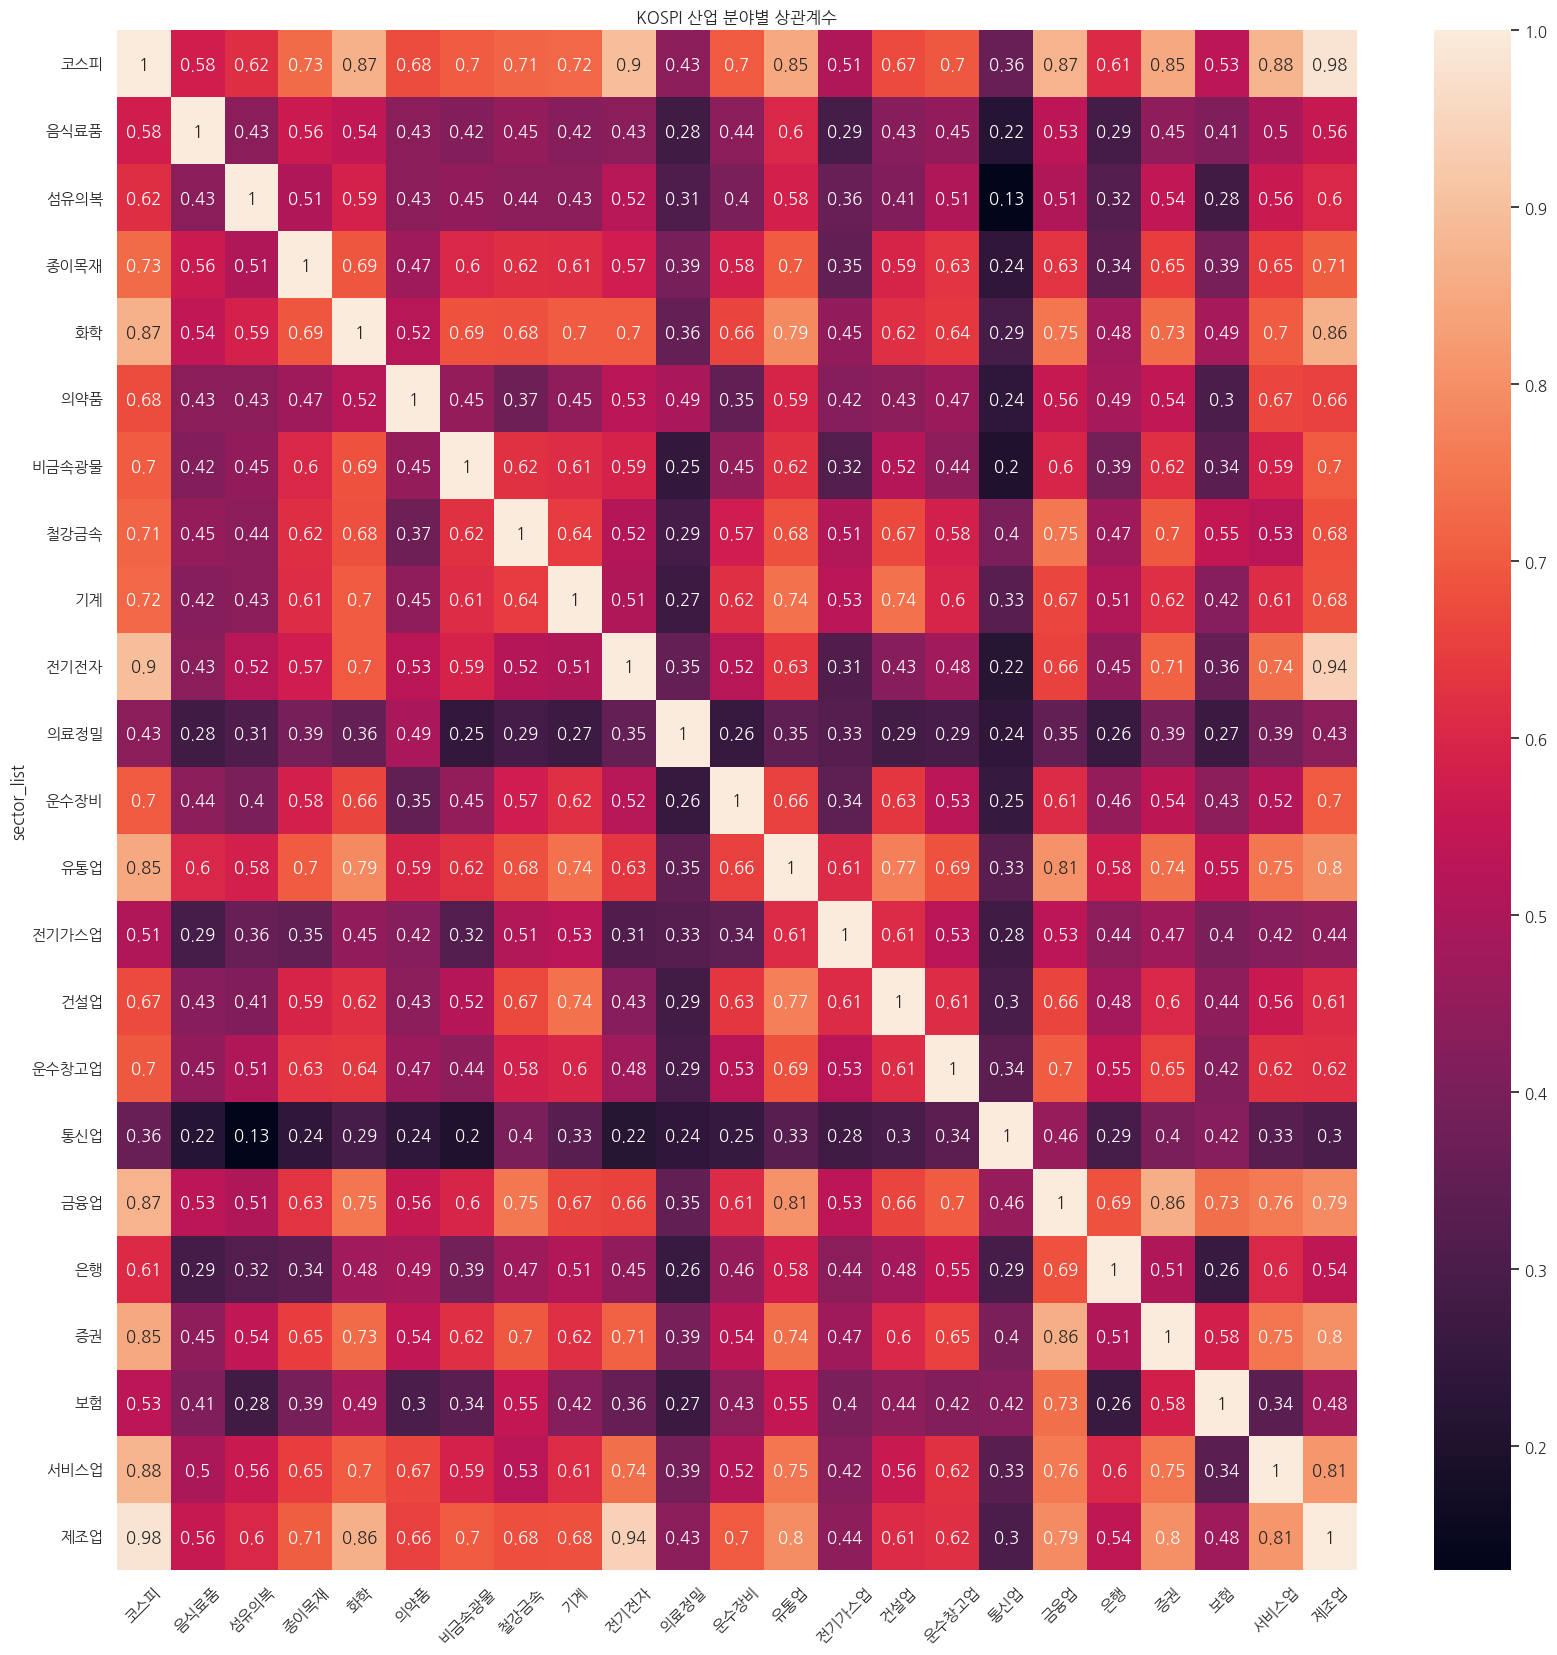

In [15]:
# Visualization: KOSPI 산업 분야별 상관계수
plt.figure(figsize=(20,20))
plt.rc('font', size=12)
plt.title('KOSPI 산업 분야별 상관계수')
sns.heatmap(corr, annot=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()